# PrimeKG Dataset Exploration

This notebook explores the PrimeKG (Precision Medicine Knowledge Graph) dataset with a focus on:
1. Full dataset overview (nodes, edges, distributions)
2. Drug-Disease relationships (indications, contraindications, off-label use)

PrimeKG is a comprehensive knowledge graph for precision medicine that integrates 20+ biomedical resources.

## 1. Setup & Dependencies

In [8]:
# Install dependencies if needed
%pip install pandas matplotlib seaborn networkx requests tqdm

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 1.0 MB/s  0:00:09m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 614.0 kB/s  0:00:13 eta 0:00:01
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 710.4 kB/s  0:00:02 eta 0:00:01
Using cached requests-2.32.5-py3-none-any.whl (64 kB)
Using cached idna-3.11-py3-none-any.whl (71 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 954.4 kB/s  0:00:03 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 991.2 kB/s  0:00:05 eta

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter
import requests
from tqdm import tqdm
import os

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

print("Dependencies loaded successfully!")

Dependencies loaded successfully!


## 2. Download PrimeKG

PrimeKG is available from Harvard Dataverse. The dataset is approximately 1GB.

In [10]:
# PrimeKG download URL from Harvard Dataverse
PRIMEKG_URL = "https://dataverse.harvard.edu/api/access/datafile/6180620"
DATA_PATH = "data/kg.csv"

def download_primekg(url, filepath, chunk_size=8192):
    """Download PrimeKG dataset with progress bar."""
    if os.path.exists(filepath):
        print(f"Dataset already exists at {filepath}")
        return
    
    print(f"Downloading PrimeKG from {url}...")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    
    with open(filepath, 'wb') as f:
        with tqdm(total=total_size, unit='B', unit_scale=True, desc="Downloading") as pbar:
            for chunk in response.iter_content(chunk_size=chunk_size):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))
    
    print(f"Download complete! Saved to {filepath}")

# Download the dataset
download_primekg(PRIMEKG_URL, DATA_PATH)

Downloading: 100%|██████████| 982M/982M [34:13<00:00, 478kB/s]    

Download complete! Saved to data/kg.csv


## 3. Load & Initial Exploration

In [11]:
# Load the dataset
print("Loading PrimeKG dataset...")
df = pd.read_csv(DATA_PATH, low_memory=False)
print(f"Dataset loaded successfully!")

Loading PrimeKG dataset...
Dataset loaded successfully!


In [12]:
# Basic dataset information
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\nShape: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1e6:.2f} MB")
print(f"\nColumns: {list(df.columns)}")

DATASET OVERVIEW

Shape: 8,100,498 rows x 12 columns
Memory usage: 4905.93 MB

Columns: ['relation', 'display_relation', 'x_index', 'x_id', 'x_type', 'x_name', 'x_source', 'y_index', 'y_id', 'y_type', 'y_name', 'y_source']


In [13]:
# Display first few rows
print("\nFirst 5 rows:")
df.head()


First 5 rows:


,relation,display_relation,x_index,x_id,x_type,x_name,x_source,y_index,y_id,y_type,y_name,y_source
0,protein_protein,ppi,0,9796,gene/protein,PHYHIP,NCBI,8889,56992,gene/protein,KIF15,NCBI
1,protein_protein,ppi,1,7918,gene/protein,GPANK1,NCBI,2798,9240,gene/protein,PNMA1,NCBI
2,protein_protein,ppi,2,8233,gene/protein,ZRSR2,NCBI,5646,23548,gene/protein,TTC33,NCBI
3,protein_protein,ppi,3,4899,gene/protein,NRF1,NCBI,11592,11253,gene/protein,MAN1B1,NCBI
4,protein_protein,ppi,4,5297,gene/protein,PI4KA,NCBI,2122,8601,gene/protein,RGS20,NCBI


In [ ]:
# Data types and non-null counts
print("\nColumn Information:")
df.info()

In [ ]:
# Sample of different edge types
print("\nSample edges from the knowledge graph:")
df.sample(10)

## 4. Node Type Analysis

In [14]:
# Get unique node types from both x_type and y_type columns
x_types = set(df['x_type'].unique())
y_types = set(df['y_type'].unique())
all_node_types = x_types.union(y_types)

print("=" * 60)
print("NODE TYPE ANALYSIS")
print("=" * 60)
print(f"\nUnique node types: {len(all_node_types)}")
print(f"Node types: {sorted(all_node_types)}")

NODE TYPE ANALYSIS

Unique node types: 10
Node types: ['anatomy', 'biological_process', 'cellular_component', 'disease', 'drug', 'effect/phenotype', 'exposure', 'gene/protein', 'molecular_function', 'pathway']


In [15]:
# Count unique nodes per type
def count_unique_nodes(df):
    """Count unique nodes for each node type."""
    node_counts = {}
    
    for node_type in all_node_types:
        # Get nodes from x side
        x_nodes = set(df[df['x_type'] == node_type]['x_id'].unique())
        # Get nodes from y side
        y_nodes = set(df[df['y_type'] == node_type]['y_id'].unique())
        # Union to get all unique nodes of this type
        node_counts[node_type] = len(x_nodes.union(y_nodes))
    
    return node_counts

node_counts = count_unique_nodes(df)
node_counts_df = pd.DataFrame([
    {'Node Type': k, 'Count': v} for k, v in node_counts.items()
]).sort_values('Count', ascending=False)

print("\nUnique nodes per type:")
print(node_counts_df.to_string(index=False))
print(f"\nTotal unique nodes: {sum(node_counts.values()):,}")


Unique nodes per type:
         Node Type  Count
biological_process  28642
      gene/protein  27610
           disease  17080
  effect/phenotype  15311
           anatomy  14033
molecular_function  11169
              drug   7957
cellular_component   4176
           pathway   2516
          exposure    818

Total unique nodes: 129,312


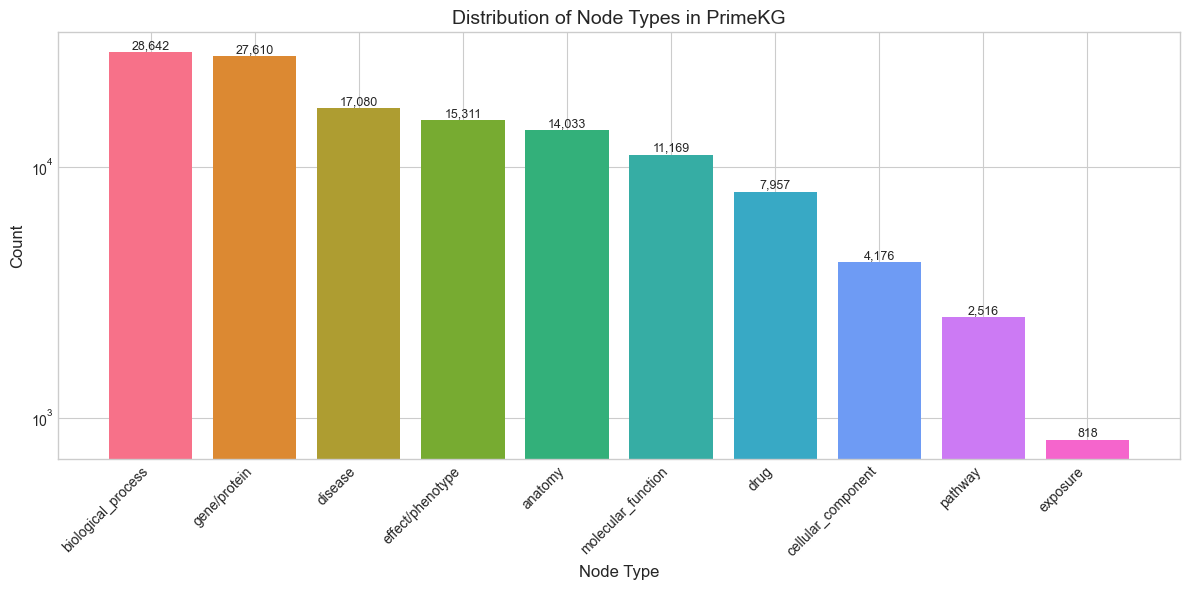

In [16]:
# Visualize node type distribution
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(node_counts_df['Node Type'], node_counts_df['Count'], color=sns.color_palette('husl', len(node_counts_df)))
ax.set_xlabel('Node Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Node Types in PrimeKG', fontsize=14)
ax.set_yscale('log')  # Log scale due to large variation
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for bar, count in zip(bars, node_counts_df['Count']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{count:,}', 
            ha='center', va='bottom', fontsize=9, rotation=0)

plt.tight_layout()
plt.show()

## 5. Edge Type Analysis

In [17]:
# Analyze edge/relation types
print("=" * 60)
print("EDGE TYPE ANALYSIS")
print("=" * 60)

relation_counts = df['relation'].value_counts()
print(f"\nUnique relation types: {len(relation_counts)}")
print(f"\nRelation type distribution:")
print(relation_counts.to_string())

EDGE TYPE ANALYSIS

Unique relation types: 30

Relation type distribution:
relation
anatomy_protein_present       3036406
drug_drug                     2672628
protein_protein                642150
disease_phenotype_positive     300634
bioprocess_protein             289610
cellcomp_protein               166804
disease_protein                160822
molfunc_protein                139060
drug_effect                    129568
bioprocess_bioprocess          105772
pathway_protein                 85292
disease_disease                 64388
contraindication                61350
drug_protein                    51306
anatomy_protein_absent          39774
phenotype_phenotype             37472
anatomy_anatomy                 28064
molfunc_molfunc                 27148
indication                      18776
cellcomp_cellcomp                9690
phenotype_protein                6660
off-label use                    5136
pathway_pathway                  5070
exposure_disease                 4608
expo

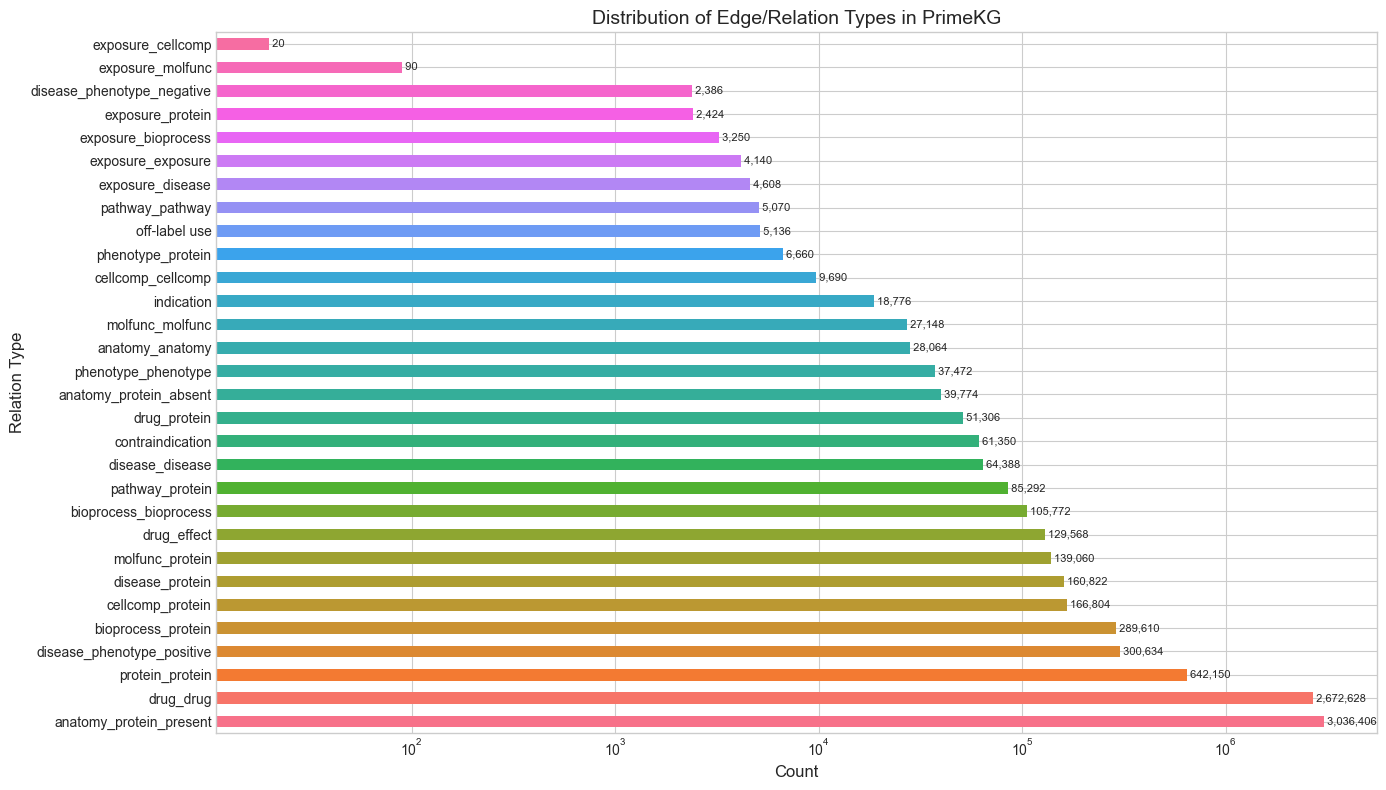

In [18]:
# Visualize edge type distribution
fig, ax = plt.subplots(figsize=(14, 8))
relation_counts.plot(kind='barh', ax=ax, color=sns.color_palette('husl', len(relation_counts)))
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Relation Type', fontsize=12)
ax.set_title('Distribution of Edge/Relation Types in PrimeKG', fontsize=14)
ax.set_xscale('log')

# Add value labels
for i, (idx, val) in enumerate(relation_counts.items()):
    ax.text(val, i, f' {val:,}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

In [19]:
# Analyze node type pairs (what connects to what)
df['edge_type_pair'] = df['x_type'] + ' -> ' + df['y_type']
edge_pair_counts = df['edge_type_pair'].value_counts()

print("\nNode type pairs (source -> target):")
print(edge_pair_counts.head(20).to_string())


Node type pairs (source -> target):
edge_type_pair
drug -> drug                                2672628
gene/protein -> anatomy                     1538090
anatomy -> gene/protein                     1538090
gene/protein -> gene/protein                 642150
disease -> effect/phenotype                  151510
effect/phenotype -> disease                  151510
gene/protein -> biological_process           144805
biological_process -> gene/protein           144805
biological_process -> biological_process     105772
gene/protein -> cellular_component            83402
cellular_component -> gene/protein            83402
gene/protein -> disease                       80411
disease -> gene/protein                       80411
gene/protein -> molecular_function            69530
molecular_function -> gene/protein            69530
drug -> effect/phenotype                      64784
effect/phenotype -> drug                      64784
disease -> disease                            64388
gene/protein

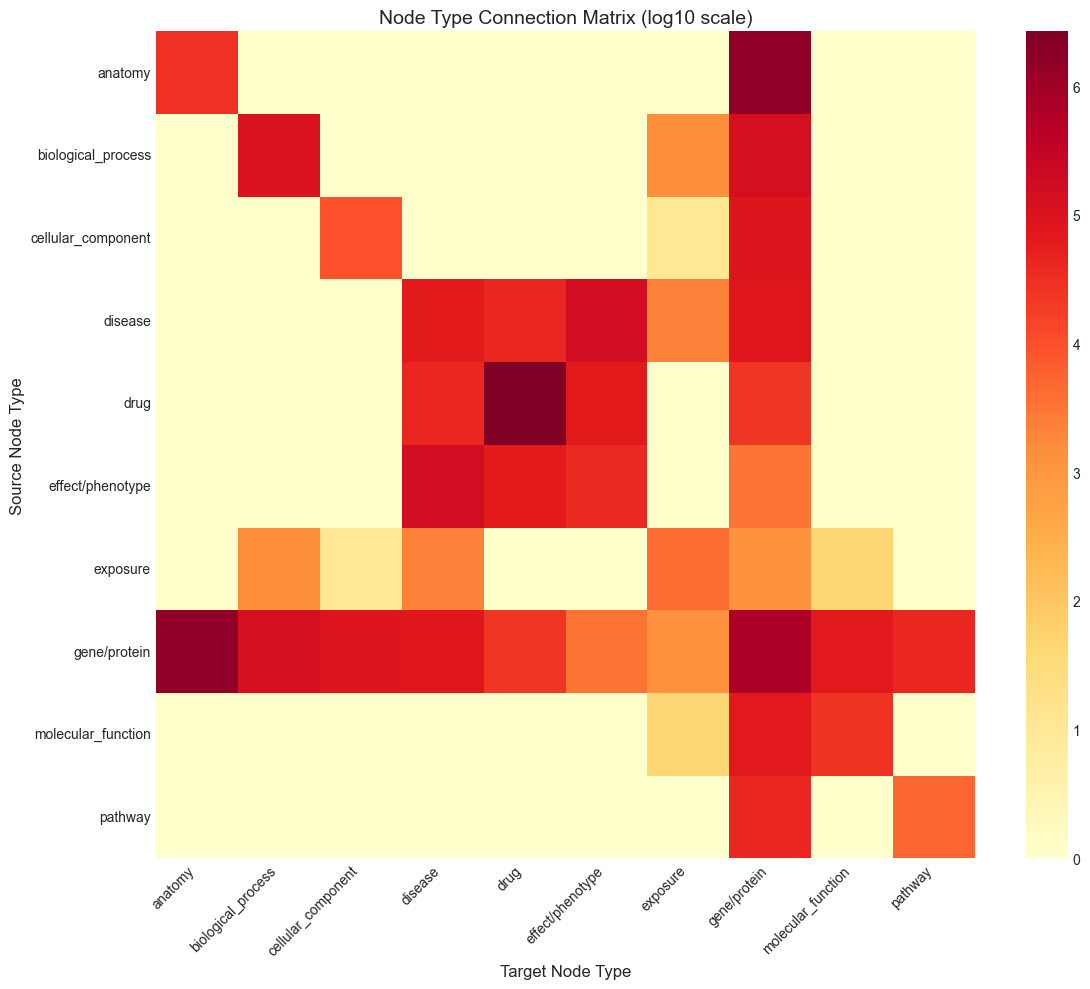

In [20]:
# Create a heatmap of node type connections
node_type_list = sorted(all_node_types)
connection_matrix = pd.DataFrame(0, index=node_type_list, columns=node_type_list)

for _, row in df.groupby(['x_type', 'y_type']).size().reset_index(name='count').iterrows():
    connection_matrix.loc[row['x_type'], row['y_type']] = row['count']

# Log transform for better visualization
connection_matrix_log = np.log10(connection_matrix + 1)

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(connection_matrix_log, annot=False, cmap='YlOrRd', ax=ax)
ax.set_title('Node Type Connection Matrix (log10 scale)', fontsize=14)
ax.set_xlabel('Target Node Type', fontsize=12)
ax.set_ylabel('Source Node Type', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 6. Graph Statistics

In [21]:
print("=" * 60)
print("GRAPH STATISTICS")
print("=" * 60)

# Total edges
total_edges = len(df)
print(f"\nTotal edges: {total_edges:,}")

# Total unique nodes
all_x_nodes = set(zip(df['x_type'], df['x_id']))
all_y_nodes = set(zip(df['y_type'], df['y_id']))
all_nodes = all_x_nodes.union(all_y_nodes)
total_nodes = len(all_nodes)
print(f"Total unique nodes: {total_nodes:,}")

# Average degree
avg_degree = (2 * total_edges) / total_nodes
print(f"Average degree: {avg_degree:.2f}")

# Graph density
max_edges = total_nodes * (total_nodes - 1) / 2
density = total_edges / max_edges
print(f"Graph density: {density:.6f}")

GRAPH STATISTICS

Total edges: 8,100,498
Total unique nodes: 129,312
Average degree: 125.29
Graph density: 0.000969


In [22]:
# Degree distribution analysis
print("\nCalculating degree distribution...")

# Count degree for each node
x_degree = df.groupby(['x_type', 'x_id']).size()
y_degree = df.groupby(['y_type', 'y_id']).size()

# Combine degrees
degree_dict = {}
for (node_type, node_id), deg in x_degree.items():
    key = (node_type, node_id)
    degree_dict[key] = degree_dict.get(key, 0) + deg
for (node_type, node_id), deg in y_degree.items():
    key = (node_type, node_id)
    degree_dict[key] = degree_dict.get(key, 0) + deg

degrees = list(degree_dict.values())

print(f"\nDegree statistics:")
print(f"  Min degree: {min(degrees)}")
print(f"  Max degree: {max(degrees)}")
print(f"  Mean degree: {np.mean(degrees):.2f}")
print(f"  Median degree: {np.median(degrees):.2f}")
print(f"  Std degree: {np.std(degrees):.2f}")


Calculating degree distribution...

Degree statistics:
  Min degree: 2
  Max degree: 34738
  Mean degree: 125.29
  Median degree: 8.00
  Std degree: 840.93


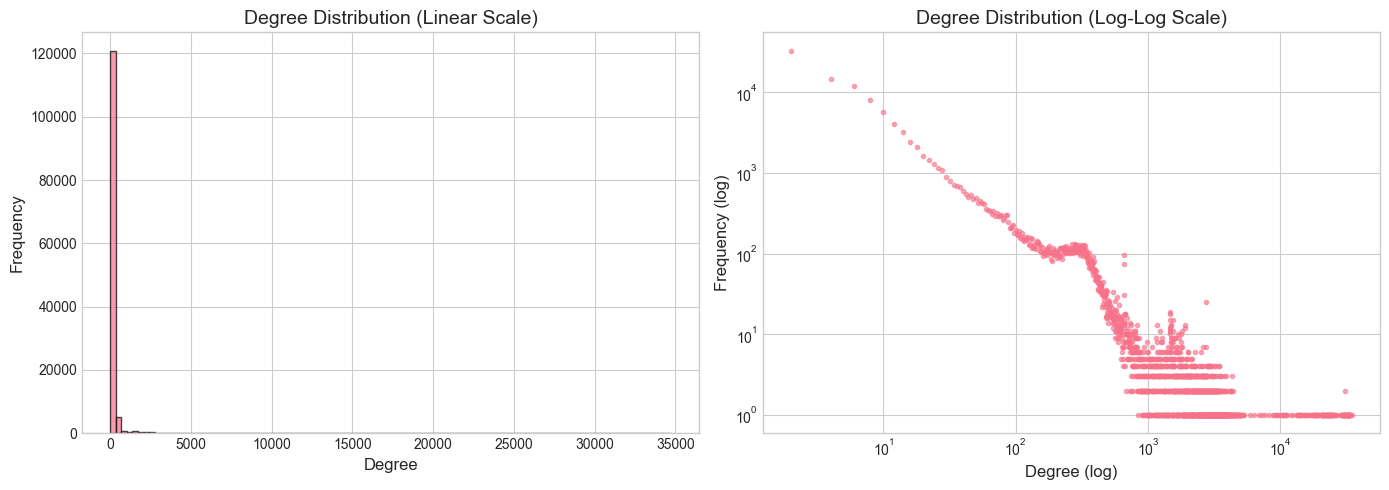

In [23]:
# Visualize degree distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale histogram
axes[0].hist(degrees, bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Degree', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Degree Distribution (Linear Scale)', fontsize=14)

# Log-log scale (power law check)
degree_counts = Counter(degrees)
deg_vals = sorted(degree_counts.keys())
deg_freqs = [degree_counts[d] for d in deg_vals]

axes[1].loglog(deg_vals, deg_freqs, 'o', markersize=3, alpha=0.6)
axes[1].set_xlabel('Degree (log)', fontsize=12)
axes[1].set_ylabel('Frequency (log)', fontsize=12)
axes[1].set_title('Degree Distribution (Log-Log Scale)', fontsize=14)

plt.tight_layout()
plt.show()

In [24]:
# Most connected nodes per type
print("\nMost connected nodes by type:")
print("=" * 60)

# Create dataframe with degrees
degree_df = pd.DataFrame([
    {'node_type': k[0], 'node_id': k[1], 'degree': v} 
    for k, v in degree_dict.items()
])

for node_type in sorted(all_node_types):
    type_df = degree_df[degree_df['node_type'] == node_type].nlargest(5, 'degree')
    if len(type_df) > 0:
        print(f"\n{node_type.upper()}:")
        # Get node names if available
        for _, row in type_df.iterrows():
            # Try to find the node name from x_name or y_name
            name_x = df[(df['x_type'] == node_type) & (df['x_id'] == row['node_id'])]['x_name'].values
            name_y = df[(df['y_type'] == node_type) & (df['y_id'] == row['node_id'])]['y_name'].values
            name = name_x[0] if len(name_x) > 0 else (name_y[0] if len(name_y) > 0 else 'Unknown')
            print(f"  ID: {row['node_id']}, Name: {name}, Degree: {row['degree']}")


Most connected nodes by type:

ANATOMY:
  ID: 468, Name: multicellular organism, Degree: 34738
  ID: 2108, Name: small intestine, Degree: 33710
  ID: 473, Name: testis, Degree: 33486
  ID: 3889, Name: fallopian tube, Degree: 33484
  ID: 2367, Name: prostate gland, Degree: 33238

BIOLOGICAL_PROCESS:
  ID: 6357, Name: regulation of transcription by RNA polymerase II, Degree: 3312
  ID: 7186, Name: G protein-coupled receptor signaling pathway, Degree: 2376
  ID: 45944, Name: positive regulation of transcription by RNA polymerase II, Degree: 2328
  ID: 7165, Name: signal transduction, Degree: 2148
  ID: 122, Name: negative regulation of transcription by RNA polymerase II, Degree: 1782

CELLULAR_COMPONENT:
  ID: 5634, Name: nucleus, Degree: 10814
  ID: 5829, Name: cytosol, Degree: 10572
  ID: 5737, Name: cytoplasm, Degree: 9460
  ID: 5886, Name: plasma membrane, Degree: 9380
  ID: 5654, Name: nucleoplasm, Degree: 7610

DISEASE:
  ID: 3847, Name: Mendelian disease, Degree: 3048
  ID: 3582, 

## 7. Drug-Disease Relationships

Deep dive into drug-disease edges including:
- **indication**: approved therapeutic uses
- **contraindication**: when drug should NOT be used  
- **off-label use**: unapproved but practiced uses

In [25]:
print("=" * 60)
print("DRUG-DISEASE RELATIONSHIP ANALYSIS")
print("=" * 60)

# Filter edges involving drugs and diseases
drug_disease_mask = (
    ((df['x_type'] == 'drug') & (df['y_type'] == 'disease')) |
    ((df['x_type'] == 'disease') & (df['y_type'] == 'drug'))
)
drug_disease_df = df[drug_disease_mask].copy()

print(f"\nTotal drug-disease edges: {len(drug_disease_df):,}")
print(f"Percentage of total edges: {100 * len(drug_disease_df) / len(df):.2f}%")

DRUG-DISEASE RELATIONSHIP ANALYSIS

Total drug-disease edges: 85,262
Percentage of total edges: 1.05%


In [26]:
# Normalize direction: always drug -> disease
def normalize_drug_disease(row):
    if row['x_type'] == 'drug':
        return pd.Series({
            'drug_id': row['x_id'],
            'drug_name': row['x_name'],
            'disease_id': row['y_id'],
            'disease_name': row['y_name'],
            'relation': row['relation']
        })
    else:
        return pd.Series({
            'drug_id': row['y_id'],
            'drug_name': row['y_name'],
            'disease_id': row['x_id'],
            'disease_name': row['x_name'],
            'relation': row['relation']
        })

drug_disease_normalized = drug_disease_df.apply(normalize_drug_disease, axis=1)
print("\nNormalized drug-disease edges (sample):")
drug_disease_normalized.head(10)


Normalized drug-disease edges (sample):


,drug_id,drug_name,disease_id,disease_name,relation
346728,DB05271,Rotigotine,5044,hypertensive disorder,contraindication
346729,DB05271,Rotigotine,1200_1134_15512_5080_100078,hypertension,contraindication
346730,DB00492,Fosinopril,5044,hypertensive disorder,indication
346731,DB00492,Fosinopril,1200_1134_15512_5080_100078,hypertension,indication
346732,DB13956,Estradiol valerate,5044,hypertensive disorder,contraindication
346733,DB13956,Estradiol valerate,1200_1134_15512_5080_100078,hypertension,contraindication
346734,DB01438,Phenazopyridine,5044,hypertensive disorder,contraindication
346735,DB01438,Phenazopyridine,1200_1134_15512_5080_100078,hypertension,contraindication
346736,DB09203,Synephrine,5044,hypertensive disorder,contraindication
346737,DB09203,Synephrine,1200_1134_15512_5080_100078,hypertension,contraindication


In [27]:
# Analyze relationship subtypes
print("\nRelationship type distribution in drug-disease edges:")
relation_dist = drug_disease_normalized['relation'].value_counts()
print(relation_dist.to_string())


Relationship type distribution in drug-disease edges:
relation
contraindication    61350
indication          18776
off-label use        5136


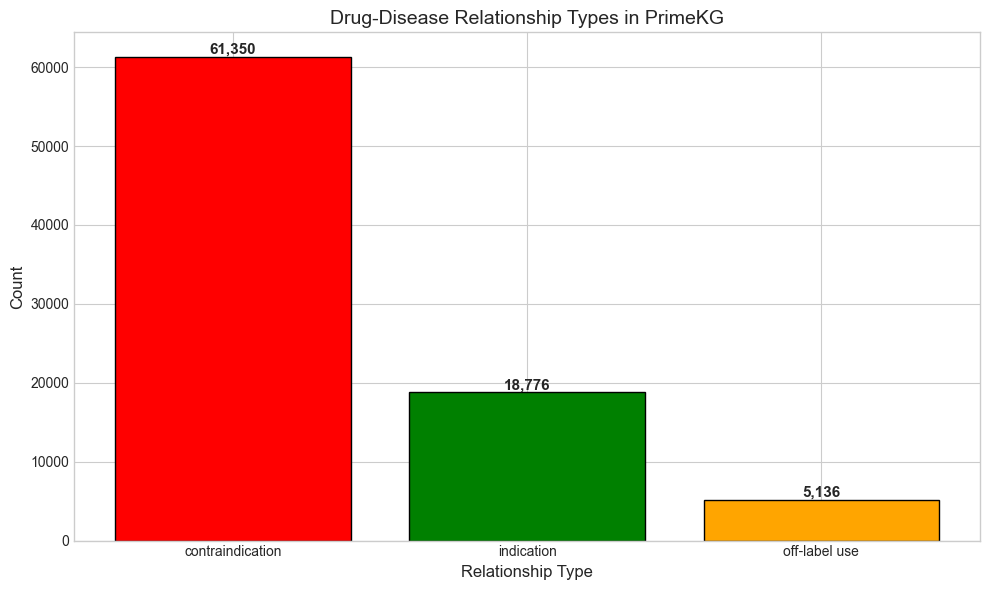

In [28]:
# Visualize drug-disease relationship types
fig, ax = plt.subplots(figsize=(10, 6))
colors = {'indication': 'green', 'contraindication': 'red', 'off-label use': 'orange'}
bar_colors = [colors.get(r, 'blue') for r in relation_dist.index]

bars = ax.bar(relation_dist.index, relation_dist.values, color=bar_colors, edgecolor='black')
ax.set_xlabel('Relationship Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Drug-Disease Relationship Types in PrimeKG', fontsize=14)

# Add value labels
for bar, val in zip(bars, relation_dist.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:,}', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

### 7.1 Indication Analysis

Indications represent approved therapeutic uses of drugs for specific diseases.

In [31]:
# Filter indications
indications = drug_disease_normalized[drug_disease_normalized['relation'] == 'indication']

print("=" * 60)
print("INDICATION ANALYSIS")
print("=" * 60)
print(f"\nTotal indication edges: {len(indications):,}")
print(f"Unique drugs with indications: {indications['drug_id'].nunique():,}")
print(f"Unique diseases with drug indications: {indications['disease_id'].nunique():,}")

INDICATION ANALYSIS

Total indication edges: 18,776
Unique drugs with indications: 1,801
Unique diseases with drug indications: 1,363


In [32]:
# Drugs with most indications
drugs_indication_count = indications.groupby(['drug_id', 'drug_name']).size().reset_index(name='indication_count')
drugs_indication_count = drugs_indication_count.sort_values('indication_count', ascending=False)

print("\nTop 20 drugs with most indications:")
print(drugs_indication_count.head(20).to_string(index=False))


Top 20 drugs with most indications:
drug_id              drug_name  indication_count
DB01380      Cortisone acetate               296
DB00860           Prednisolone               292
DB01234          Dexamethasone               288
DB00741         Hydrocortisone               278
DB00620          Triamcinolone               258
DB00443          Betamethasone               246
DB00959     Methylprednisolone               236
DB00635             Prednisone               218
DB14539 Hydrocortisone acetate               192
DB02703           Fusidic acid               188
DB00997            Doxorubicin               170
DB01053       Benzylpenicillin               126
DB00681         Amphotericin B               106
DB00262             Carmustine               104
DB00254            Doxycycline               102
DB01059            Norfloxacin               100
DB01165              Ofloxacin                92
DB01017            Minocycline                82
DB04572               Thiotepa  

In [33]:
# Diseases with most drug indications
diseases_indication_count = indications.groupby(['disease_id', 'disease_name']).size().reset_index(name='drug_count')
diseases_indication_count = diseases_indication_count.sort_values('drug_count', ascending=False)

print("\nTop 20 diseases with most drug indications:")
print(diseases_indication_count.head(20).to_string(index=False))


Top 20 diseases with most drug indications:
                                                     disease_id                      disease_name  drug_count
                                                           5044             hypertensive disorder         206
                                    1200_1134_15512_5080_100078                      hypertension         206
                                                           6004                vasomotor rhinitis         174
                                               11786_5324_24332                 allergic rhinitis         174
                                                           2258                       pharyngitis         148
                                                           8383              rheumatoid arthritis         136
                                                           5709                       common cold         134
                                                           5642            

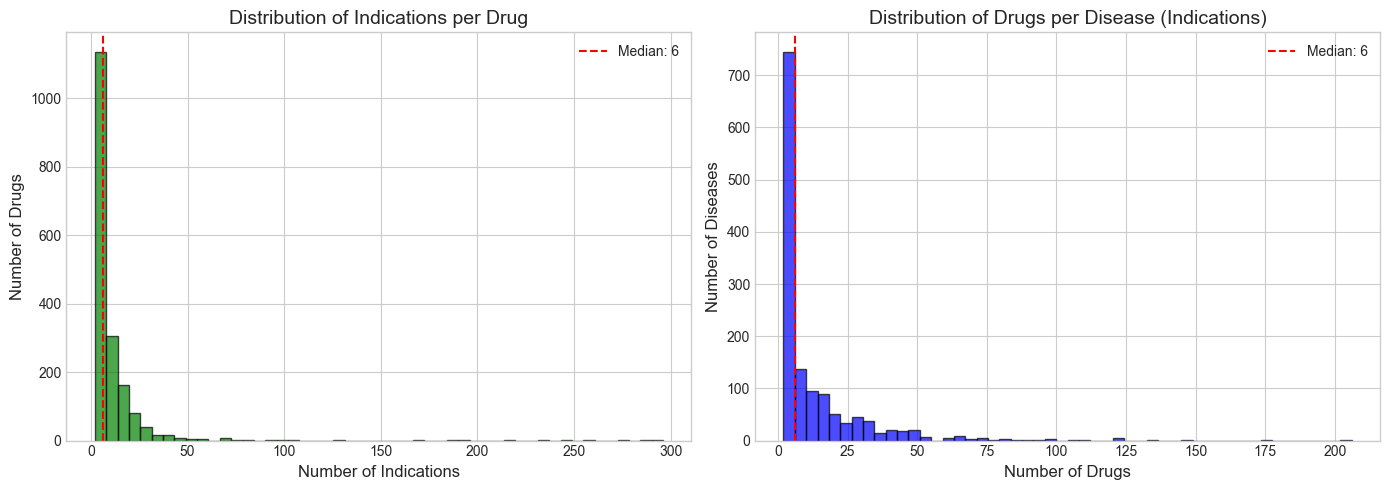

In [34]:
# Distribution of indications per drug
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Indications per drug
axes[0].hist(drugs_indication_count['indication_count'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0].set_xlabel('Number of Indications', fontsize=12)
axes[0].set_ylabel('Number of Drugs', fontsize=12)
axes[0].set_title('Distribution of Indications per Drug', fontsize=14)
axes[0].axvline(drugs_indication_count['indication_count'].median(), color='red', linestyle='--', label=f'Median: {drugs_indication_count["indication_count"].median():.0f}')
axes[0].legend()

# Drugs per disease
axes[1].hist(diseases_indication_count['drug_count'], bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[1].set_xlabel('Number of Drugs', fontsize=12)
axes[1].set_ylabel('Number of Diseases', fontsize=12)
axes[1].set_title('Distribution of Drugs per Disease (Indications)', fontsize=14)
axes[1].axvline(diseases_indication_count['drug_count'].median(), color='red', linestyle='--', label=f'Median: {diseases_indication_count["drug_count"].median():.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()

### 7.2 Contraindication Analysis

Contraindications represent cases where a drug should NOT be used for a specific disease or condition.

In [35]:
# Filter contraindications
contraindications = drug_disease_normalized[drug_disease_normalized['relation'] == 'contraindication']

print("=" * 60)
print("CONTRAINDICATION ANALYSIS")
print("=" * 60)
print(f"\nTotal contraindication edges: {len(contraindications):,}")
print(f"Unique drugs with contraindications: {contraindications['drug_id'].nunique():,}")
print(f"Unique diseases as contraindications: {contraindications['disease_id'].nunique():,}")

CONTRAINDICATION ANALYSIS

Total contraindication edges: 61,350
Unique drugs with contraindications: 1,263
Unique diseases as contraindications: 1,195


In [36]:
# Drugs with most contraindications
drugs_contra_count = contraindications.groupby(['drug_id', 'drug_name']).size().reset_index(name='contraindication_count')
drugs_contra_count = drugs_contra_count.sort_values('contraindication_count', ascending=False)

print("\nTop 20 drugs with most contraindications:")
print(drugs_contra_count.head(20).to_string(index=False))


Top 20 drugs with most contraindications:
drug_id           drug_name  contraindication_count
DB13719         Trolnitrate                     418
DB00201            Caffeine                     344
DB01174       Phenobarbital                     328
DB00388       Phenylephrine                     328
DB01364           Ephedrine                     294
DB00874         Guaifenesin                     284
DB01620         Pheniramine                     280
DB00514    Dextromethorphan                     278
DB00318             Codeine                     278
DB00475    Chlordiazepoxide                     272
DB01114    Chlorpheniramine                     270
DB00783           Estradiol                     256
DB00880      Chlorothiazide                     256
DB00999 Hydrochlorothiazide                     254
DB00852     Pseudoephedrine                     236
DB00956         Hydrocodone                     230
DB00367      Levonorgestrel                     228
DB00977    Ethinylest

In [37]:
# Diseases most commonly contraindicated
diseases_contra_count = contraindications.groupby(['disease_id', 'disease_name']).size().reset_index(name='drug_count')
diseases_contra_count = diseases_contra_count.sort_values('drug_count', ascending=False)

print("\nTop 20 diseases/conditions with most contraindicated drugs:")
print(diseases_contra_count.head(20).to_string(index=False))


Top 20 diseases/conditions with most contraindicated drugs:
                                             disease_id                    disease_name  drug_count
                                       5281_12365_12366             gallbladder disease        1308
                                                   5154                   liver disease        1308
                                                   1922                       pyoureter        1164
                                                   5240                  kidney disease        1164
                                                  12819           diabetic ketoacidosis         690
                                                   5015     diabetes mellitus (disease)         686
                                                   5027                        epilepsy         620
                            1200_1134_15512_5080_100078                    hypertension         616
                                       

### 7.3 Off-Label Use Analysis

Off-label uses represent unapproved but clinically practiced uses of drugs for diseases.

In [38]:
# Filter off-label uses
off_label = drug_disease_normalized[drug_disease_normalized['relation'] == 'off-label use']

print("=" * 60)
print("OFF-LABEL USE ANALYSIS")
print("=" * 60)
print(f"\nTotal off-label use edges: {len(off_label):,}")
print(f"Unique drugs with off-label uses: {off_label['drug_id'].nunique():,}")
print(f"Unique diseases with off-label drug uses: {off_label['disease_id'].nunique():,}")

OFF-LABEL USE ANALYSIS

Total off-label use edges: 5,136
Unique drugs with off-label uses: 483
Unique diseases with off-label drug uses: 750


In [39]:
# Drugs with most off-label uses
drugs_offlabel_count = off_label.groupby(['drug_id', 'drug_name']).size().reset_index(name='offlabel_count')
drugs_offlabel_count = drugs_offlabel_count.sort_values('offlabel_count', ascending=False)

print("\nTop 20 drugs with most off-label uses:")
print(drugs_offlabel_count.head(20).to_string(index=False))


Top 20 drugs with most off-label uses:
drug_id          drug_name  offlabel_count
DB00773          Etoposide             118
DB01168       Procarbazine              90
DB00958        Carboplatin              84
DB00860       Prednisolone              78
DB01380  Cortisone acetate              78
DB00959 Methylprednisolone              68
DB01234      Dexamethasone              66
DB00443      Betamethasone              62
DB00635         Prednisone              62
DB00620      Triamcinolone              60
DB00199       Erythromycin              60
DB00563       Methotrexate              54
DB01248          Docetaxel              50
DB00675          Tamoxifen              50
DB02703       Fusidic acid              50
DB01229         Paclitaxel              48
DB01033     Mercaptopurine              46
DB01101       Capecitabine              44
DB00440       Trimethoprim              44
DB00351  Megestrol acetate              42


In [40]:
# Diseases with most off-label drug uses
diseases_offlabel_count = off_label.groupby(['disease_id', 'disease_name']).size().reset_index(name='drug_count')
diseases_offlabel_count = diseases_offlabel_count.sort_values('drug_count', ascending=False)

print("\nTop 20 diseases with most off-label drug uses:")
print(diseases_offlabel_count.head(20).to_string(index=False))


Top 20 diseases with most off-label drug uses:
                                                     disease_id                        disease_name  drug_count
                                                           5719      Coronavinae infectious disease          60
                                                           4981       atrial fibrillation (disease)          42
                                                           6727             diastolic heart failure          42
                                            4985_693_24613_1866                    bipolar disorder          36
                                                          21667                           neuralgia          36
                                                          18645 IgG4-related sclerosing cholangitis          34
                                                           1928             suppurative cholangitis          34
                                                        

In [41]:
# Compare drugs across all three relationship types
print("\n" + "=" * 60)
print("COMPARISON ACROSS RELATIONSHIP TYPES")
print("=" * 60)

# Merge drug counts
drug_comparison = drugs_indication_count[['drug_id', 'drug_name', 'indication_count']].merge(
    drugs_contra_count[['drug_id', 'contraindication_count']], on='drug_id', how='outer'
).merge(
    drugs_offlabel_count[['drug_id', 'offlabel_count']], on='drug_id', how='outer'
).fillna(0)

drug_comparison['total'] = drug_comparison['indication_count'] + drug_comparison['contraindication_count'] + drug_comparison['offlabel_count']
drug_comparison = drug_comparison.sort_values('total', ascending=False)

print("\nTop 20 drugs by total drug-disease relationships:")
print(drug_comparison.head(20).to_string(index=False))


COMPARISON ACROSS RELATIONSHIP TYPES

Top 20 drugs by total drug-disease relationships:
drug_id              drug_name  indication_count  contraindication_count  offlabel_count  total
DB01380      Cortisone acetate             296.0                   192.0            78.0  566.0
DB00860           Prednisolone             292.0                   166.0            78.0  536.0
DB01234          Dexamethasone             288.0                   166.0            66.0  520.0
DB00443          Betamethasone             246.0                   192.0            62.0  500.0
DB00620          Triamcinolone             258.0                   168.0            60.0  486.0
DB00741         Hydrocortisone             278.0                   180.0            18.0  476.0
DB00959     Methylprednisolone             236.0                   138.0            68.0  442.0
DB13719                      0               0.0                   418.0             6.0  424.0
DB00635             Prednisone             218.

## 8. Visualizations

In [42]:
# Create a sample drug-disease subgraph visualization
print("Creating drug-disease subgraph visualization...")

# Sample top drugs and their disease connections
top_drugs = drug_comparison.head(10)['drug_id'].tolist()
sample_edges = drug_disease_normalized[drug_disease_normalized['drug_id'].isin(top_drugs)]

# Limit edges per drug for visualization
sample_edges_limited = sample_edges.groupby('drug_id').head(5)

print(f"Sample subgraph: {len(top_drugs)} drugs, {len(sample_edges_limited)} edges")

Creating drug-disease subgraph visualization...
Sample subgraph: 10 drugs, 50 edges


In [43]:
# Build NetworkX graph
G = nx.Graph()

# Add edges with attributes
for _, row in sample_edges_limited.iterrows():
    drug_node = f"DRUG: {row['drug_name'][:30]}"
    disease_node = f"DISEASE: {row['disease_name'][:30]}"
    G.add_node(drug_node, node_type='drug')
    G.add_node(disease_node, node_type='disease')
    G.add_edge(drug_node, disease_node, relation=row['relation'])

print(f"Graph created: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Graph created: 23 nodes, 50 edges


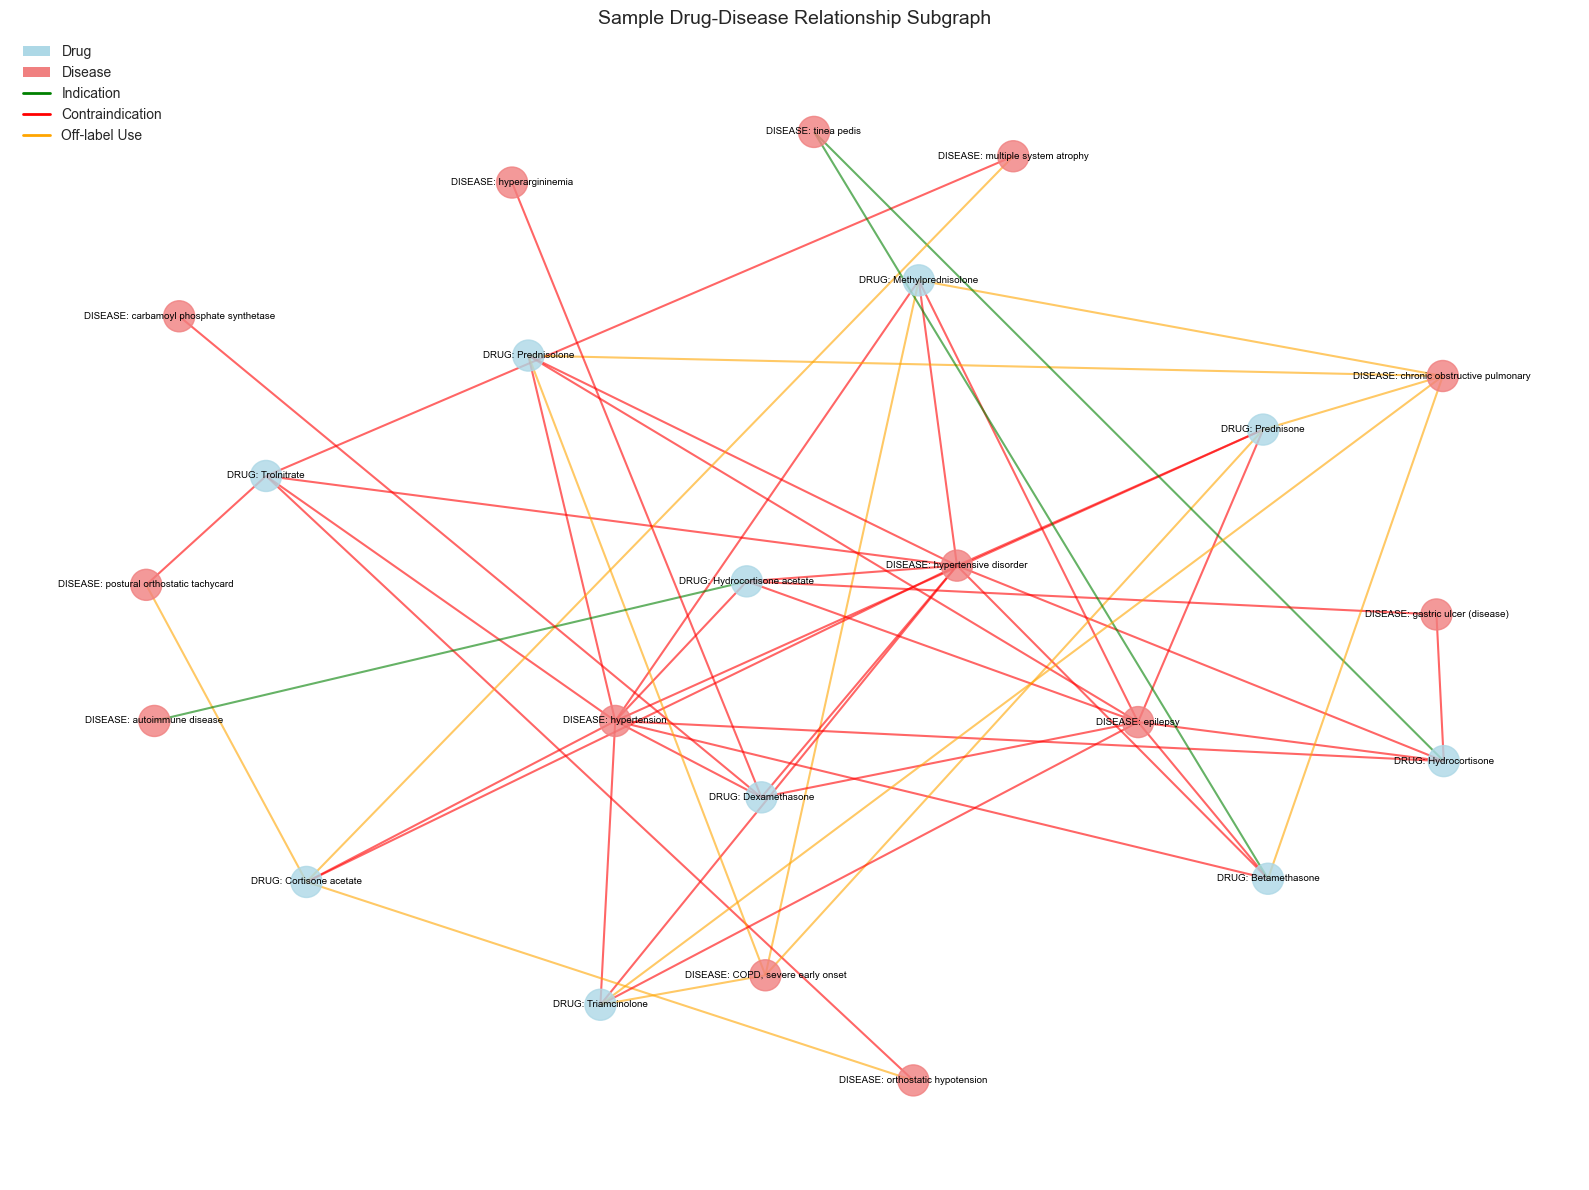

In [44]:
# Visualize the subgraph
fig, ax = plt.subplots(figsize=(16, 12))

# Set node colors based on type
node_colors = ['lightblue' if G.nodes[n].get('node_type') == 'drug' else 'lightcoral' for n in G.nodes()]

# Set edge colors based on relation
edge_colors = []
for u, v, d in G.edges(data=True):
    if d['relation'] == 'indication':
        edge_colors.append('green')
    elif d['relation'] == 'contraindication':
        edge_colors.append('red')
    else:  # off-label
        edge_colors.append('orange')

# Layout
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

# Draw
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, alpha=0.8, ax=ax)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1.5, alpha=0.6, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=7, ax=ax)

# Legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Patch(facecolor='lightblue', label='Drug'),
    Patch(facecolor='lightcoral', label='Disease'),
    Line2D([0], [0], color='green', linewidth=2, label='Indication'),
    Line2D([0], [0], color='red', linewidth=2, label='Contraindication'),
    Line2D([0], [0], color='orange', linewidth=2, label='Off-label Use')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

ax.set_title('Sample Drug-Disease Relationship Subgraph', fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

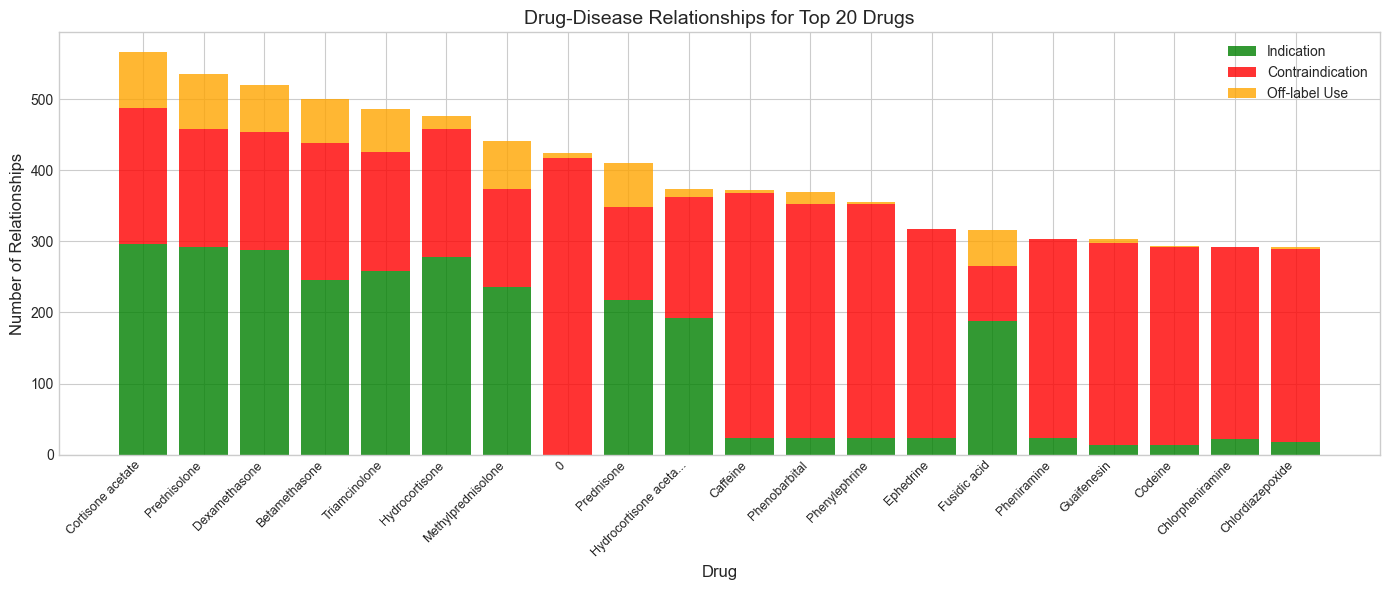

In [45]:
# Stacked bar chart: relationship types per top drug
fig, ax = plt.subplots(figsize=(14, 6))

top_20_drugs = drug_comparison.head(20).copy()
x = range(len(top_20_drugs))
width = 0.8

ax.bar(x, top_20_drugs['indication_count'], width, label='Indication', color='green', alpha=0.8)
ax.bar(x, top_20_drugs['contraindication_count'], width, bottom=top_20_drugs['indication_count'], 
       label='Contraindication', color='red', alpha=0.8)
ax.bar(x, top_20_drugs['offlabel_count'], width, 
       bottom=top_20_drugs['indication_count'] + top_20_drugs['contraindication_count'],
       label='Off-label Use', color='orange', alpha=0.8)

ax.set_xlabel('Drug', fontsize=12)
ax.set_ylabel('Number of Relationships', fontsize=12)
ax.set_title('Drug-Disease Relationships for Top 20 Drugs', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([n[:20] + '...' if len(str(n)) > 20 else n for n in top_20_drugs['drug_name']], 
                   rotation=45, ha='right', fontsize=9)
ax.legend()

plt.tight_layout()
plt.show()

## 9. Summary & Next Steps

In [46]:
# Create summary statistics table
print("=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)

summary_stats = {
    'Metric': [
        'Total Edges',
        'Total Unique Nodes',
        'Unique Node Types',
        'Unique Relation Types',
        'Average Degree',
        '---',
        'Drug-Disease Edges',
        'Indication Edges',
        'Contraindication Edges',
        'Off-label Use Edges',
        '---',
        'Unique Drugs (in drug-disease)',
        'Unique Diseases (in drug-disease)',
        'Avg Indications per Drug',
        'Avg Drugs per Disease (Indication)'
    ],
    'Value': [
        f"{total_edges:,}",
        f"{total_nodes:,}",
        f"{len(all_node_types)}",
        f"{len(relation_counts)}",
        f"{avg_degree:.2f}",
        '---',
        f"{len(drug_disease_normalized):,}",
        f"{len(indications):,}",
        f"{len(contraindications):,}",
        f"{len(off_label):,}",
        '---',
        f"{drug_disease_normalized['drug_id'].nunique():,}",
        f"{drug_disease_normalized['disease_id'].nunique():,}",
        f"{drugs_indication_count['indication_count'].mean():.2f}",
        f"{diseases_indication_count['drug_count'].mean():.2f}"
    ]
}

summary_df = pd.DataFrame(summary_stats)
print(summary_df.to_string(index=False))

SUMMARY STATISTICS
                            Metric     Value
                       Total Edges 8,100,498
                Total Unique Nodes   129,312
                 Unique Node Types        10
             Unique Relation Types        30
                    Average Degree    125.29
                               ---       ---
                Drug-Disease Edges    85,262
                  Indication Edges    18,776
            Contraindication Edges    61,350
               Off-label Use Edges     5,136
                               ---       ---
    Unique Drugs (in drug-disease)     2,074
 Unique Diseases (in drug-disease)     2,054
          Avg Indications per Drug     10.43
Avg Drugs per Disease (Indication)     13.78


In [47]:
# Save filtered subgraphs for future GNN work
print("\nSaving filtered subgraphs for future GNN work...")

# Save drug-disease relationships
drug_disease_normalized.to_csv('data/drug_disease_edges.csv', index=False)
print(f"Saved: data/drug_disease_edges.csv ({len(drug_disease_normalized):,} edges)")

# Save indications only
indications.to_csv('data/drug_disease_indications.csv', index=False)
print(f"Saved: data/drug_disease_indications.csv ({len(indications):,} edges)")

# Save contraindications only
contraindications.to_csv('data/drug_disease_contraindications.csv', index=False)
print(f"Saved: data/drug_disease_contraindications.csv ({len(contraindications):,} edges)")

# Save off-label uses only
off_label.to_csv('data/drug_disease_offlabel.csv', index=False)
print(f"Saved: data/drug_disease_offlabel.csv ({len(off_label):,} edges)")


Saving filtered subgraphs for future GNN work...
Saved: data/drug_disease_edges.csv (85,262 edges)
Saved: data/drug_disease_indications.csv (18,776 edges)
Saved: data/drug_disease_contraindications.csv (61,350 edges)
Saved: data/drug_disease_offlabel.csv (5,136 edges)


In [48]:
# Key findings and insights
print("\n" + "=" * 60)
print("KEY FINDINGS & INSIGHTS")
print("=" * 60)

print("""
1. DATASET SCALE:
   - PrimeKG is a comprehensive biomedical knowledge graph
   - Contains multiple node types including genes, proteins, drugs, diseases, etc.
   - Degree distribution follows power-law pattern (scale-free network)

2. DRUG-DISEASE RELATIONSHIPS:
   - Three main relationship types: indication, contraindication, off-label use
   - Indications are the most common relationship type
   - Some drugs have many indications (broad-spectrum therapeutics)
   - Some diseases have many drug options (well-studied conditions)

3. GNN CONSIDERATIONS:
   - Heterogeneous graph structure (multiple node and edge types)
   - Imbalanced edge types may require sampling strategies
   - Rich features available from node names and IDs
   - Drug-disease subgraph suitable for link prediction tasks

4. NEXT STEPS:
   - Build GNN models for drug-disease interaction prediction
   - Consider multi-relational learning approaches
   - Integrate drug and disease features from external sources
   - Evaluate on held-out indication/contraindication edges
""")

print("\nNotebook exploration complete!")


KEY FINDINGS & INSIGHTS

1. DATASET SCALE:
   - PrimeKG is a comprehensive biomedical knowledge graph
   - Contains multiple node types including genes, proteins, drugs, diseases, etc.
   - Degree distribution follows power-law pattern (scale-free network)

2. DRUG-DISEASE RELATIONSHIPS:
   - Three main relationship types: indication, contraindication, off-label use
   - Indications are the most common relationship type
   - Some drugs have many indications (broad-spectrum therapeutics)
   - Some diseases have many drug options (well-studied conditions)

3. GNN CONSIDERATIONS:
   - Heterogeneous graph structure (multiple node and edge types)
   - Imbalanced edge types may require sampling strategies
   - Rich features available from node names and IDs
   - Drug-disease subgraph suitable for link prediction tasks

4. NEXT STEPS:
   - Build GNN models for drug-disease interaction prediction
   - Consider multi-relational learning approaches
   - Integrate drug and disease features from 